<a href="https://colab.research.google.com/github/nathanzilgo/Audio-Processing/blob/main/music_generation_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (2.1.1-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [49]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [52]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Dataset do MAESTRO:
investigar e testar esse aqui tb:
http://www.piano-midi.de/

In [53]:
chopin_dir = pathlib.Path('data/chopinMidi')
chopin_origin = 'http://www.piano-midi.de/zip/chopin.zip'
chopin_fname = 'chopin.zip'
maestro_origin = 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'
maestro_dir = pathlib.Path('data/maestro-v2.0.0')

In [57]:

if not chopin_dir.exists():
  tf.keras.utils.get_file(
      chopin_fname,
      origin= chopin_origin,
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [61]:
filenames = glob.glob(str('data/*.mid*'))
print('Number of files:', len(filenames))


Number of files: 48


In [62]:
sample_file = filenames[0]
print(sample_file)

data/chpn-p24.mid


In [63]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [64]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [65]:
display_audio(pm)

In [66]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 2
Instrument name: Acoustic Grand Piano


In [67]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=69, note_name=A4, duration=0.5212
1: pitch=65, note_name=F4, duration=0.2700
2: pitch=62, note_name=D4, duration=1.5844
3: pitch=65, note_name=F4, duration=0.2606
4: pitch=69, note_name=A4, duration=0.3909
5: pitch=74, note_name=D5, duration=0.1303
6: pitch=72, note_name=C5, duration=1.4386
7: pitch=70, note_name=A#4, duration=0.1320
8: pitch=69, note_name=A4, duration=0.7819
9: pitch=69, note_name=A4, duration=0.1344


In [68]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [69]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,69,3.155373,3.676614,0.000000,0.521241
1,65,3.676614,3.946592,0.521241,0.269979
2,62,3.946592,5.530962,0.269979,1.584369
3,65,5.530962,5.791582,1.584369,0.260620
4,69,5.791582,6.182513,0.260620,0.390931


In [70]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A4', 'F4', 'D4', 'F4', 'A4', 'D5', 'C5', 'A#4', 'A4', 'A4'],
      dtype='<U3')

In [71]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

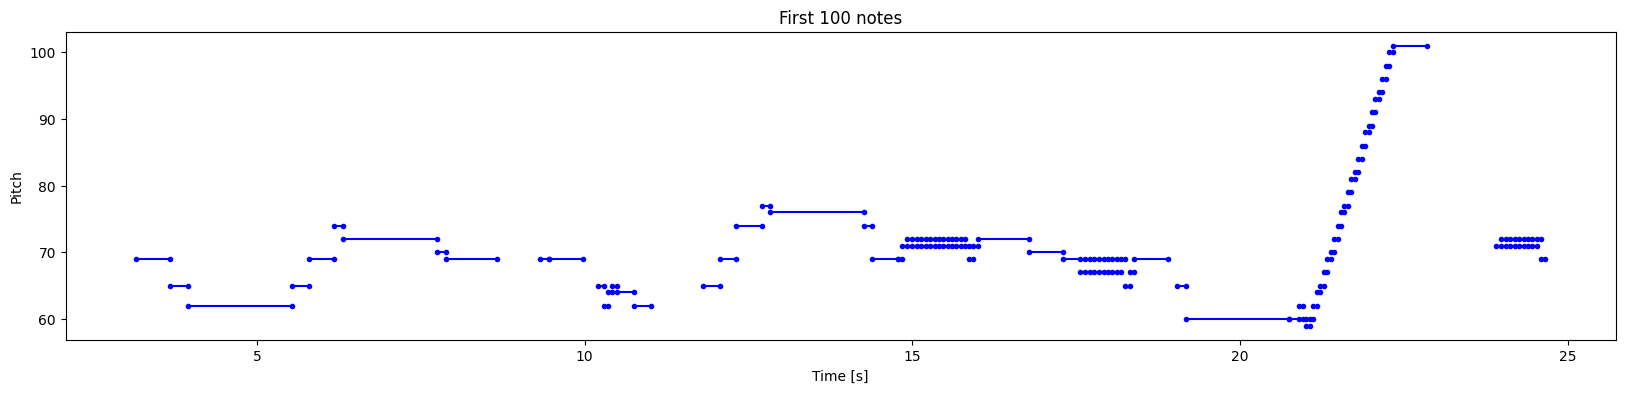

In [72]:
plot_piano_roll(raw_notes, count=100)

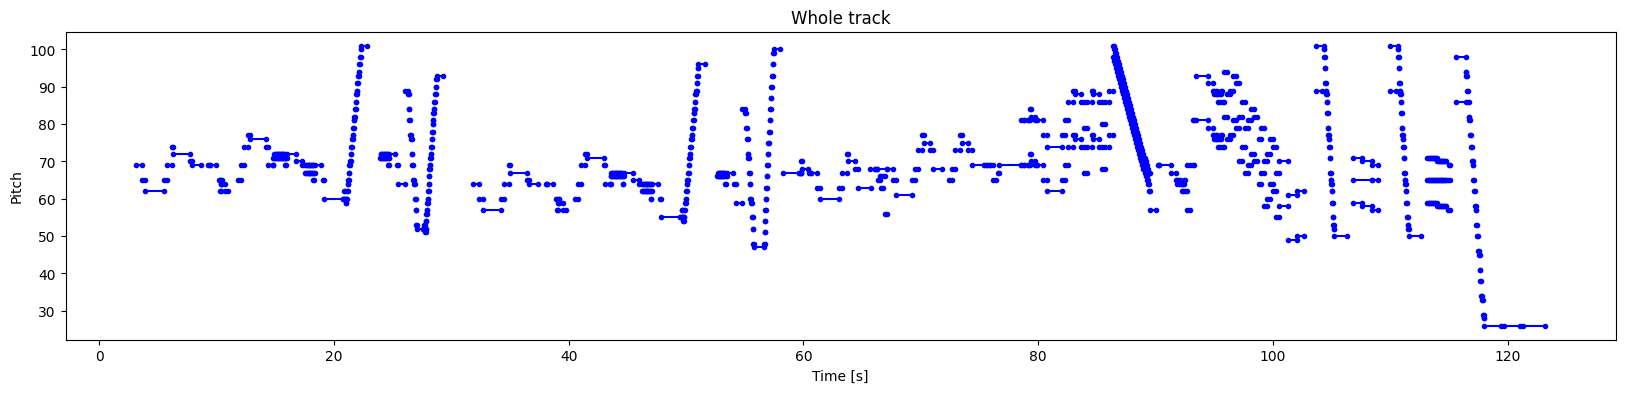

In [73]:
plot_piano_roll(raw_notes)

In [74]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

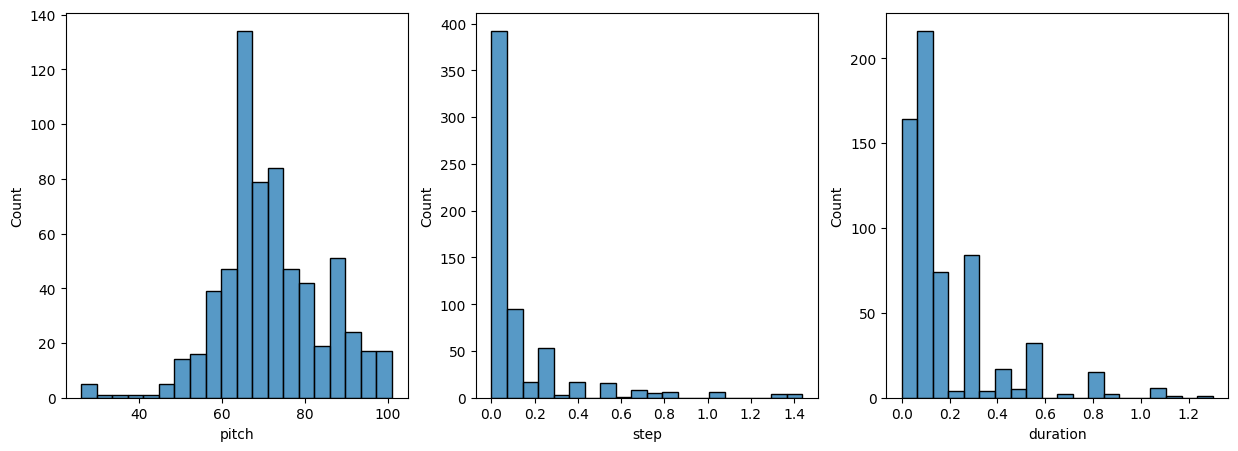

In [75]:
plot_distributions(raw_notes)

In [76]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [77]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [78]:
display_audio(example_pm)

In [79]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [80]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 3370


## Criação de DataSet das notas processadas:

In [81]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [82]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [83]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use hyperparameter tuning. The size of the vocabulary (vocab_size) is set to 128 representing all the pitches supported by pretty_midi.



In [84]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [85]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.5390625  0.         0.521241  ]
 [0.5078125  0.521241   0.2699785 ]
 [0.484375   0.2699785  1.584369  ]
 [0.5078125  1.584369   0.2606205 ]
 [0.5390625  0.2606205  0.39093075]
 [0.578125   0.39093075 0.13031025]
 [0.5625     0.13031025 1.43857425]
 [0.546875   1.43857425 0.13203075]
 [0.5390625  0.13203075 0.7818615 ]
 [0.5390625  1.437499   0.1343965 ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=71.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.06601537499999921>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.06601537500000099>}


In [86]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [87]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Treino do modelo:

In [88]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [89]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

Testing the model.evaluate function, you can see that the pitch loss is significantly greater than the step and duration losses. Note that loss is the total loss computed by summing all the other losses and is currently dominated by the pitch loss.

In [90]:
losses = model.evaluate(train_ds, return_dict=True)
losses

52/52 [==============================] - 4s 19ms/step - loss: 5.6579 - duration_loss: 0.4448 - pitch_loss: 4.8511 - step_loss: 0.3621


{'loss': 5.6579108238220215,
 'duration_loss': 0.44478878378868103,
 'pitch_loss': 4.851069450378418,
 'step_loss': 0.3620527982711792}

In [91]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [92]:
model.evaluate(train_ds, return_dict=True)

52/52 [==============================] - 4s 39ms/step - loss: 1.0494 - duration_loss: 0.4448 - pitch_loss: 4.8511 - step_loss: 0.3621


{'loss': 1.0493950843811035,
 'duration_loss': 0.44478878378868103,
 'pitch_loss': 4.851069450378418,
 'step_loss': 0.3620527982711792}

In [93]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [94]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
52/52 [==============================] - 7s 69ms/step - loss: 0.5378 - duration_loss: 0.1874 - pitch_loss: 4.4361 - step_loss: 0.1286
Epoch 2/50
52/52 [==============================] - 2s 41ms/step - loss: 0.4691 - duration_loss: 0.1701 - pitch_loss: 3.9581 - step_loss: 0.1011
Epoch 3/50
52/52 [==============================] - 2s 44ms/step - loss: 0.4319 - duration_loss: 0.1633 - pitch_loss: 3.7527 - step_loss: 0.0810
Epoch 4/50
52/52 [==============================] - 4s 82ms/step - loss: 0.4170 - duration_loss: 0.1612 - pitch_loss: 3.7042 - step_loss: 0.0706
Epoch 5/50
52/52 [==============================] - 3s 64ms/step - loss: 0.4129 - duration_loss: 0.1593 - pitch_loss: 3.7071 - step_loss: 0.0683
Epoch 6/50
52/52 [==============================] - 2s 41ms/step - loss: 0.4054 - duration_loss: 0.1567 - pitch_loss: 3.6887 - step_loss: 0.0642
Epoch 7/50
52/52 [==============================] - 2s 41ms/step - loss: 0.3933 - duration_loss: 0.1538 - pitch_loss: 3.6606 - ste

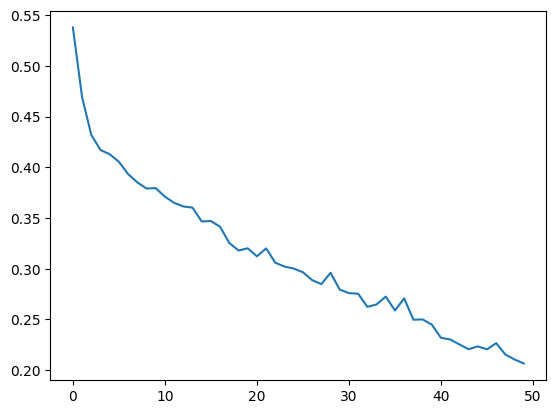

In [95]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [96]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [97]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 34ms/step


In [98]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,71,0.121511,0.225800,0.121511,0.347311
1,100,0.686253,0.487267,0.807764,1.295030
2,100,0.855029,0.486238,1.662793,2.149031
3,100,0.861017,0.464603,2.523810,2.988413
4,100,0.842796,0.475629,3.366606,3.842235
5,100,0.835208,0.480893,4.201814,4.682707
6,96,0.848502,0.468592,5.050316,5.518908
7,100,0.860652,0.454008,5.910968,6.364976
8,89,0.845065,0.471014,6.756034,7.227047
9,100,0.861520,0.443892,7.617553,8.061445


In [99]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

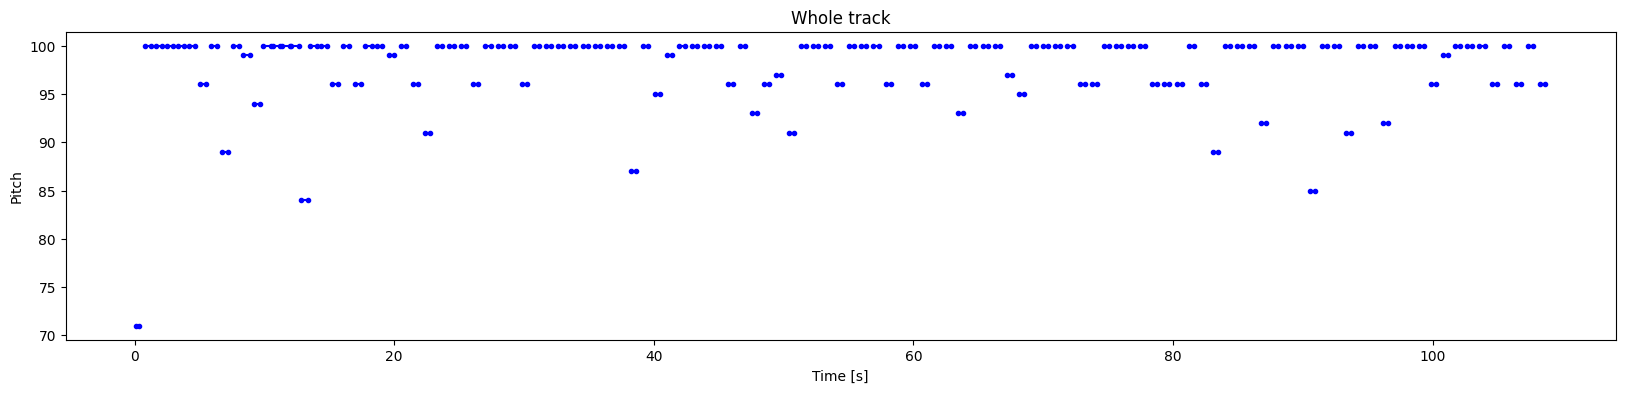

In [100]:
plot_piano_roll(generated_notes)

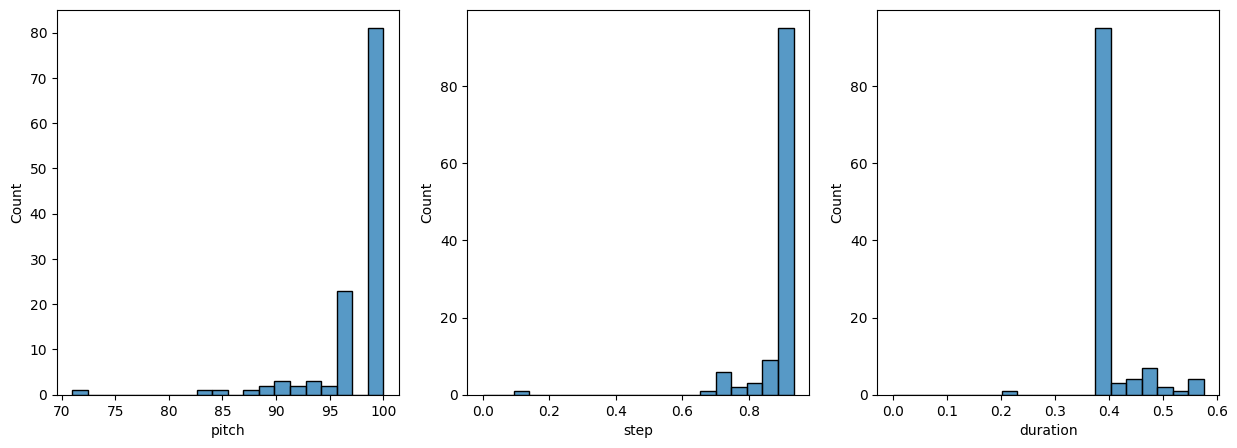

In [101]:
plot_distributions(generated_notes)